In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [12]:
player_salary_data = pd.read_csv("data/player_salaries_with_positions.csv")

In [13]:
player_salary_data.head()

,player_name,salary,salary_inflation_adj,season,team,regular_season,cleaned_names,PLAYER_ID,regular_seasons,PERSON_ID,HEIGHT,WEIGHT,POSITION,five_positions,three_positions
0,A.C. Green,1750000.0,3450733.0,1990-1991,Los Angeles Lakers,1990,AC Green,920.0,21990,920.0,81,225.0,Forward,Forward,Forward
1,A.C. Green,1750000.0,3295957.0,1991-1992,Los Angeles Lakers,1991,AC Green,920.0,21991,920.0,81,225.0,Forward,Forward,Forward
2,A.C. Green,1750000.0,3197220.0,1992-1993,Los Angeles Lakers,1992,AC Green,920.0,21992,920.0,81,225.0,Forward,Forward,Forward
3,A.C. Green,1885000.0,3343694.0,1993-1994,Phoenix Suns,1993,AC Green,920.0,21993,920.0,81,225.0,Forward,Forward,Forward
4,A.C. Green,6472600.0,11202102.0,1994-1995,Phoenix Suns,1994,AC Green,920.0,21994,920.0,81,225.0,Forward,Forward,Forward


# Cleaning Positions

The NBA uses G / F / C nomenclature for their positions, while realgm.com uses a mix of things, so I need to get them all onto the same position map. Due to most of the data being from stats.nba.com, I am going to use the G / F / C positions.

TO-DO: use guard / wing / big instead of G / F / C

In [17]:
mixed_to_five_position_map = {
    "Forward-Center": "PF",
    "Guard-Forward": "SG",
    "Forward-Guard": "SF",
    "Center-Forward": "C"
}

five_to_three_position_map = {
    "PG": "Guard",
    "SG": "Guard",
    "SF": "Forward",
    "PF": "Forward",
    "C": "Center"
}

In [18]:
player_salary_data["five_positions"] = player_salary_data.POSITION.apply(
    lambda x: mixed_to_five_position_map[x] if x in mixed_to_five_position_map else x
)
player_salary_data.five_positions.unique()

array(['Forward', 'C', 'Guard', 'Center', 'PG', 'PF', 'SG', 'SF'],
      dtype=object)

In [20]:
player_salary_data["three_positions"] = player_salary_data.five_positions.apply(
    lambda x: five_to_three_position_map[x] if x in five_to_three_position_map else x
)
player_salary_data.three_positions.unique()

array(['Forward', 'Center', 'Guard'], dtype=object)

# Missing Player Salary Seasons

In [14]:
player_salary_data.loc[
    player_salary_data.player_name.isna()
].shape[0]

493

In [15]:
player_salary_data.loc[
    player_salary_data.player_name.isna()
].cleaned_names.nunique()

395

There are 395 unique players with missing salary seasons, and 493 total instances of missing salary seasons.

In [16]:
player_salary_data.loc[
    player_salary_data.player_name.isna()
].groupby("regular_season").PLAYER_ID.count()

regular_season
1990    39
1991    33
1992    27
1993    44
1994    28
1995    22
1996    46
1997    34
1998    26
1999     9
2000    17
2001    17
2002    12
2003    24
2004    24
2005    13
2006     6
2007     9
2008     5
2009     6
2010     7
2011    24
2012     2
2013    11
2014     4
2015     1
2016     3
Name: PLAYER_ID, dtype: int64

As we can see, most of the missing salaries are from 2005 and before. The high number of missing salaries from 2011 is likely due to the lockout shortened season.

# Graphing It

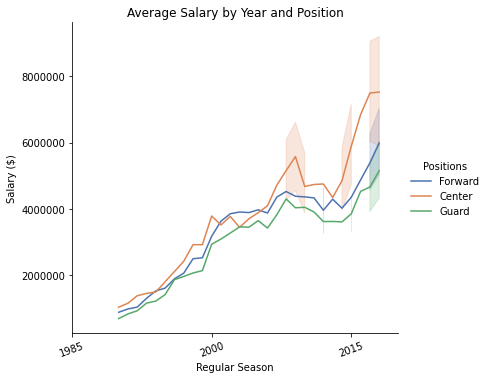

In [29]:
g = sns.relplot(
    x="regular_season",
    y="salary",
    kind="line",
    hue="three_positions",
    data=player_salary_data,
    palette="deep"
)

g.set_xticklabels(step = 3, rotation=20)
sns.utils.plt.ticklabel_format(style='plain', axis='y',useOffset=False)
g.set(
    title="Average Salary by Year and Position", 
    xlabel="Regular Season",
    ylabel="Salary ($)",
)
g._legend.set_title("Positions")
#g.savefig("data/salary_by_year_and_position_basic_line.png")

In [39]:
position_yearly_salary_pct = (
    player_salary_data.groupby(
        ["regular_season", "three_positions"]
    ).salary.sum() / player_salary_data.groupby(
        ["regular_season"]
    ).salary.sum()
).reset_index().rename(columns={"salary":"salary_pct"})

In [40]:
position_yearly_salary_pct

,regular_season,three_positions,salary_pct
0,1990,Center,0.284625
1,1990,Forward,0.399154
2,1990,Guard,0.316221
3,1991,Center,0.272616
4,1991,Forward,0.391794
...,...,...,...
82,2017,Forward,0.381816
83,2017,Guard,0.421704
84,2018,Center,0.185866
85,2018,Forward,0.389913


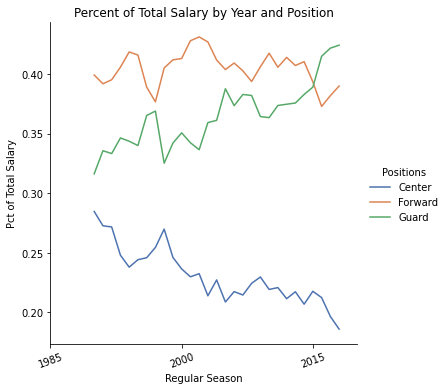

In [43]:
g = sns.relplot(
    x="regular_season",
    y="salary_pct",
    kind="line",
    hue="three_positions",
    data=position_yearly_salary_pct,
    palette="deep"
)

g.set_xticklabels(step = 3, rotation=20)
sns.utils.plt.ticklabel_format(style='plain', axis='y',useOffset=False)
g.set(
    title="Percent of Total Salary by Year and Position", 
    xlabel="Regular Season",
    ylabel="Pct of Total Salary",
)
g._legend.set_title("Positions")

In [44]:
player_salary_data.groupby("regular_season").three_positions.value_counts()

regular_season  three_positions
1990            Guard              152
                Forward            151
                Center              90
1991            Guard              166
                Forward            162
                                  ... 
2017            Forward            238
                Center              88
2018            Guard              297
                Forward            235
                Center              89
Name: three_positions, Length: 87, dtype: int64

# Adding in Salary Cap

In [45]:
salary_caps = pd.read_csv("data/NBA_yearly_salary_caps.csv")

In [46]:
salary_caps.head()

,Season,Salary Cap,Luxury Tax,BAE,Standard /Non-Taxpayer MLE,Taxpayer MLE,Team Room /Under Cap MLE
0,2027-2028,167513000,202355000.0,5562000.0,14210000.0,8776000.0,7317000.0
1,2026-2027,159536000,192719000.0,5297000.0,13533000.0,8358000.0,6969000.0
2,2025-2026,151939000,183542000.0,5045000.0,12889000.0,7960000.0,6637000.0
3,2024-2025,144704000,174802000.0,4805000.0,12275000.0,7581000.0,6321000.0
4,2023-2024,137813000,166478000.0,4576000.0,11690000.0,7220000.0,6020000.0
